In [1]:
import numpy as np
import pandas as pd
import random

from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Dense, GRU, Input, BatchNormalization, Dropout
from ncps.wirings import AutoNCP
from ncps.keras import LTC

2025-04-08 13:56:42.667409: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 13:56:42.676336: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 13:56:42.696858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744109802.735911    1213 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744109802.745916    1213 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 13:56:42.785954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Configuration

In [2]:
NUM_EPOCHS = 80
NUM_EXPERIMENTS = 1

def create_model(train):
    model = Sequential()
    model.add(Input(shape=(train.shape[1], train.shape[2])))

    model.add(Conv1D(filters=50, kernel_size=3, activation='relu', padding='causal'))

    model.add(LTC(AutoNCP(64, 32), return_sequences=True))
    model.add(LTC(AutoNCP(32, 16), return_sequences=False))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.002, weight_decay=1e-7, use_ema=True), loss='binary_crossentropy', metrics=["accuracy", AUC(name="auc")])
    return model

# Experiment

In [3]:
ID = ["ID"]
USER = ["SubjectID"]
IDS = ["SubjectID", "VideoID"]
TARGET = ["predefinedlabel"]
FEATURES = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", "Gamma2"]
LAGS = []
INIT_SEED = 5412

In [4]:
data_dir = Path("/home/aseliverstov/projects/brain_signals/data")
data = pd.read_csv(data_dir / "EEG_data.csv")

new_features = []
for lag in LAGS:
    for feature_name in FEATURES:
        new_feature_name = f"{feature_name}_{lag}"
        new_features.append(new_feature_name)
        data[new_feature_name] = data.groupby(IDS)[feature_name].shift(lag).fillna(0)
FEATURES.extend(new_features)

data["ID"] = (len(np.unique(data["VideoID"])) * data["SubjectID"] + data["VideoID"]).astype("int")
data = data[ID + USER + FEATURES + TARGET]

data.head(3)

,ID,SubjectID,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel
0,0,0.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,0,0.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,0,0.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0


In [5]:
def reshape_dataset(data):
    features = []
    target = []
    for cur_id in np.unique(data[ID].to_numpy()):
        cur_id_data = data[data[ID].to_numpy() == cur_id]
        target.append(np.mean(cur_id_data[TARGET].to_numpy()).astype("int"))
        features.append(cur_id_data[FEATURES].to_numpy())

    features = pad_sequences(features)
    return np.array(features), np.array(target)

def pad_sequences(arrays, pad_value=0):
    max_length = max(arr.shape[0] for arr in arrays)
    padded_arrays = [
        np.pad(
            arr,
            ((0, max_length - arr.shape[0]), (0, 0)),
            mode='constant',
            constant_values=pad_value)
            for arr in arrays
        ]
    return np.stack(padded_arrays)

In [6]:
X, _ = reshape_dataset(data)
model = create_model(X)
model.summary()

2025-04-08 13:56:48.310322: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 144, 50)        │         1,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ltc (LTC)                       │ (None, 144, 32)        │        29,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ltc_1 (LTC)                     │ (None, 16)             │         8,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,191 (153.09 KB)

 Trainable params: 39,191 (153.09 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
%%time

all_acc = []
all_loss = []
all_auc = []

all_val_acc = []
all_val_loss = []
all_val_auc = []

for j, seed in tqdm(enumerate(np.arange(NUM_EXPERIMENTS) + INIT_SEED)):
    np.random.seed(int(seed))
    random.seed(int(seed))
    tf.random.set_seed(int(seed))

    train_id = np.random.choice(np.unique(np.ravel(data[USER])), 7, replace=False)
    train_index = np.isin(data[USER], train_id)

    train = data.iloc[train_index]
    test = data.iloc[~train_index]

    X_train, y_train = reshape_dataset(train)
    X_test, y_test = reshape_dataset(test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    model = create_model(X_train)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=NUM_EPOCHS,
        batch_size=10,
        verbose=1,
    )

    acc = history.history['accuracy']
    loss = history.history['loss']
    auc = history.history['auc']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    val_auc = history.history['val_auc']

    all_acc.append(acc)
    all_loss.append(loss)
    all_auc.append(auc)

    all_val_acc.append(val_acc)
    all_val_loss.append(val_loss)
    all_val_auc.append(val_auc)

epoch_acc = np.mean(all_acc, axis=0)
epoch_loss = np.mean(all_loss, axis=0)
epoch_auc = np.mean(all_auc, axis=0)

epoch_val_acc = np.mean(all_val_acc, axis=0)
epoch_val_loss = np.mean(all_val_loss, axis=0)
epoch_val_auc = np.mean(all_val_auc, axis=0)

0it [00:00, ?it/s]

Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5335 - auc: 0.4566 - loss: 0.6961 - val_accuracy: 0.5000 - val_auc: 0.8178 - val_loss: 0.6950
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5335 - auc: 0.6426 - loss: 0.6862 - val_accuracy: 0.5000 - val_auc: 0.7889 - val_loss: 0.6739
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5335 - auc: 0.7132 - loss: 0.6708 - val_accuracy: 0.7000 - val_auc: 0.7889 - val_loss: 0.6536
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6964 - auc: 0.7195 - loss: 0.6557 - val_accuracy: 0.8333 - val_auc: 0.8222 - val_loss: 0.6223
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7615 - auc: 0.7190 - loss: 0.6336 - val_accuracy: 0.8333 - val_auc: 0.8222 - val_loss: 0.5899
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7615 - auc: 0.7092 - loss: 0.6090 - val_accuracy: 0.8333 - val_auc: 0.8222 - val_loss: 0.5511
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7615 - 

1it [12:15, 735.91s/it]

CPU times: user 25min 13s, sys: 9min 11s, total: 34min 25s
Wall time: 12min 15s


In [8]:
for i in range(NUM_EPOCHS):
    print(f"Epoch {(i + 1)}: TRAIN Accuracy = {np.round(epoch_acc[i], 3)} Loss = {np.round(epoch_loss[i], 3)} AUC = {np.round(epoch_auc[i], 3)}")
    print(f"Epoch {(i + 1)}: VAL Accuracy = {np.round(epoch_val_acc[i], 3)} Loss = {np.round(epoch_val_loss[i], 3)} AUC = {np.round(epoch_val_auc[i], 3)}")

Epoch 1: TRAIN Accuracy = 0.5 Loss = 0.703 AUC = 0.556
Epoch 1: VAL Accuracy = 0.5 Loss = 0.695 AUC = 0.818
Epoch 2: TRAIN Accuracy = 0.5 Loss = 0.689 AUC = 0.702
Epoch 2: VAL Accuracy = 0.5 Loss = 0.674 AUC = 0.789
Epoch 3: TRAIN Accuracy = 0.5 Loss = 0.67 AUC = 0.759
Epoch 3: VAL Accuracy = 0.7 Loss = 0.654 AUC = 0.789
Epoch 4: TRAIN Accuracy = 0.757 Loss = 0.65 AUC = 0.77
Epoch 4: VAL Accuracy = 0.833 Loss = 0.622 AUC = 0.822
Epoch 5: TRAIN Accuracy = 0.8 Loss = 0.621 AUC = 0.777
Epoch 5: VAL Accuracy = 0.833 Loss = 0.59 AUC = 0.822
Epoch 6: TRAIN Accuracy = 0.8 Loss = 0.588 AUC = 0.749
Epoch 6: VAL Accuracy = 0.833 Loss = 0.551 AUC = 0.822
Epoch 7: TRAIN Accuracy = 0.8 Loss = 0.554 AUC = 0.784
Epoch 7: VAL Accuracy = 0.833 Loss = 0.514 AUC = 0.822
Epoch 8: TRAIN Accuracy = 0.8 Loss = 0.521 AUC = 0.787
Epoch 8: VAL Accuracy = 0.833 Loss = 0.477 AUC = 0.822
Epoch 9: TRAIN Accuracy = 0.8 Loss = 0.495 AUC = 0.775
Epoch 9: VAL Accuracy = 0.833 Loss = 0.453 AUC = 0.856
Epoch 10: TRAIN Ac

In [9]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

def plot_time_series_with_shap(model, X_train, X_test, y_test, j, feature_names, lags=None):
    X_sample, y_sample = X_test[j], y_test[j]
    background = X_train

    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(np.expand_dims(X_sample, axis=0))[0]
    shap_values = np.squeeze(shap_values)

    num_features = len(feature_names)
    if lags is not None:
        num_features = int(num_features / (1 + len(lags)))
        shap_values = shap_values.reshape(-1, 1 + len(lags), num_features)

        for k, lag in enumerate(lags):
            shap_values[:, k + 1, :] = np.roll(shap_values[:, k + 1, :], shift=lag, axis=0)
            shap_values[:lag, k + 1, :] = 0
        shap_values = np.sum(shap_values, axis=1)

    plt.figure(figsize=(15, 8))
    red_colors = cm.Reds(np.linspace(0.2, 0.9, num_features))  # More color variation in red
    blue_colors = cm.Blues(np.linspace(0.2, 0.9, num_features))  # More color variation in blue
    
    scatter_plots = []
    for i in range(num_features):
        cur_feature_shap_values = shap_values[:, i]
        ts = np.arange(X_sample.shape[0])
        c = [red_colors[i] if el > 0 else blue_colors[i] for el in cur_feature_shap_values]
        s = [250000 * np.abs(el) if 250000 * np.abs(el) > 0.05 else 0.05 for el in cur_feature_shap_values]
        
        plt.scatter(ts, X_sample[:, i], color=c, s=s)
        scatter_plots.append((red_colors[i], blue_colors[i], feature_names[i]))
    
    raw_prediction = model.predict(np.expand_dims(X_sample, axis=0))
    prediction = 'Confused' if raw_prediction > 0.5 else 'Not Confused'
    plt.yscale('log')
    plt.xlabel("Timestep")
    plt.ylabel("Feature Value (Log Scale)")
    
    # Custom legend with both blueish and reddish markers
    legend_handles = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=red, markersize=5, label=name)
        for red, blue, name in scatter_plots
    ] + [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=blue, markersize=5)
        for _, blue, _ in scatter_plots
    ]
    legend_labels = [name for _, _, name in scatter_plots] + ["" for _ in scatter_plots]
    
    plt.legend(handles=legend_handles, labels=legend_labels, loc="upper right", ncol=2, handletextpad=1.5)
    plt.title(f"Sample {j}. True value '{'Confused' if y_sample == 1 else 'Not Confused'}'. Predicted '{prediction}': {np.round(raw_prediction, 2)}%")
    plt.show()

/home/aseliverstov/.cache/pypoetry/virtualenvs/brain-signals-_5HxkjSc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/aseliverstov/.cache/pypoetry/virtualenvs/brain-signals-_5HxkjSc-py3.10/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(1, 144, 8))']
  warnings.warn(msg)
/home/aseliverstov/.cache/pypoetry/virtualenvs/brain-signals-_5HxkjSc-py3.10/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(50, 144, 8))']
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


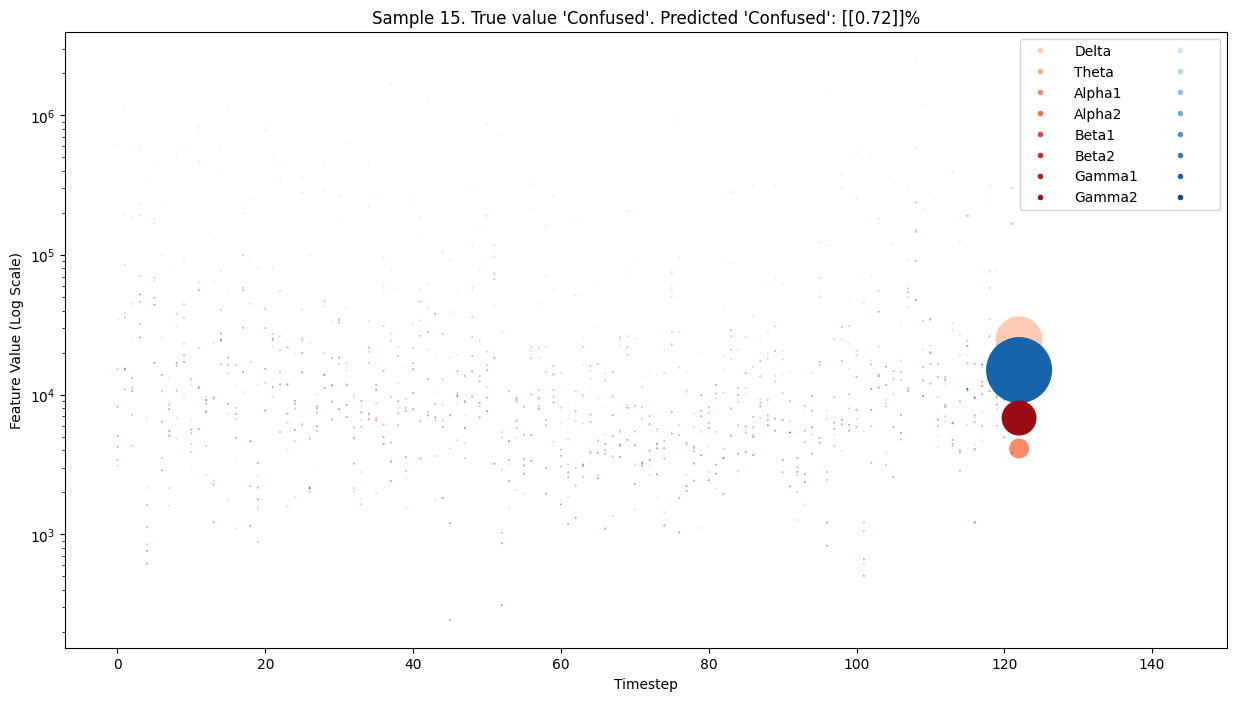

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


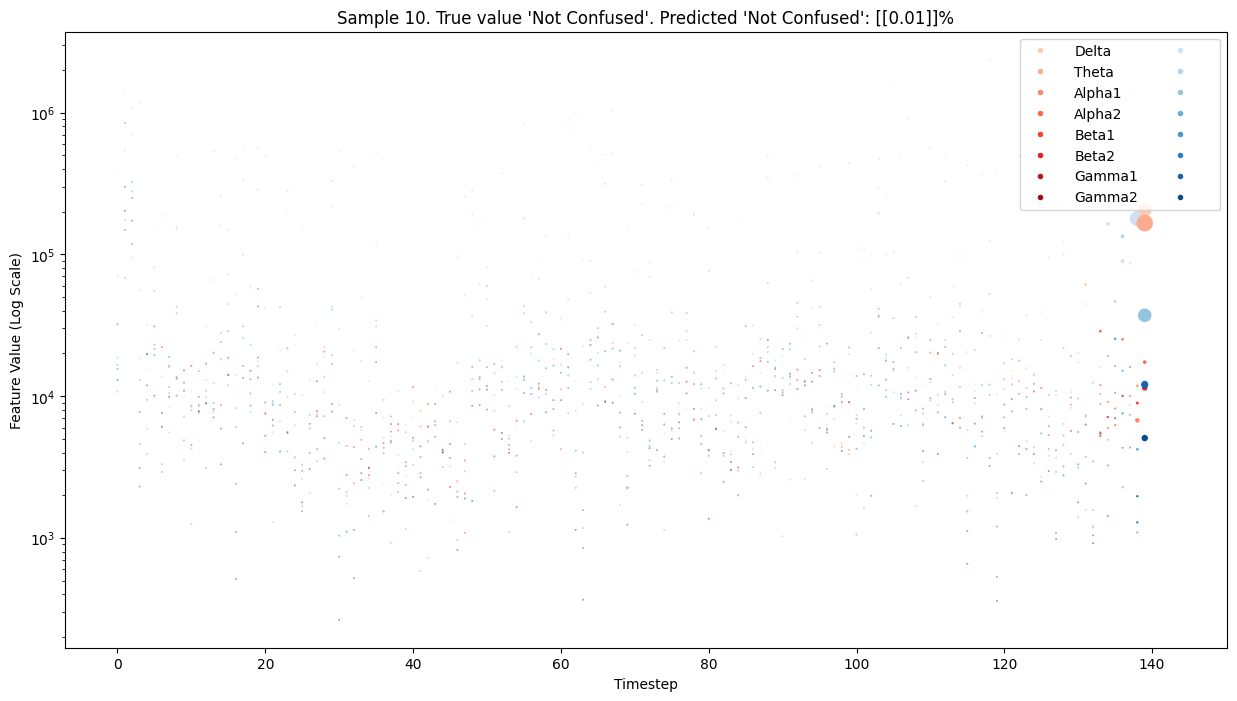

In [10]:
plot_time_series_with_shap(model, X_train, X_test, y_test, 15, FEATURES, LAGS)
plot_time_series_with_shap(model, X_train, X_test, y_test, 10, FEATURES, LAGS)